In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [336]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

In [337]:
print(test["date"].max())
test["date"].describe()

2019-12-31


count          98550
unique          1095
top       2017-01-01
freq              90
Name: date, dtype: object

In [338]:
train["date"] = pd.to_datetime(train["date"])
train.head(2)

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0


In [339]:
mask = (train['country'] == 'Canada') & (train['product'] == 'Kaggle Tiers') & (train['store'] == 'Discount Stickers')
train[mask]

,date,country,store,product,num_sold
id,,,,,
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
92,2010-01-02,Canada,Discount Stickers,Kaggle Tiers,854.0
182,2010-01-03,Canada,Discount Stickers,Kaggle Tiers,839.0
272,2010-01-04,Canada,Discount Stickers,Kaggle Tiers,609.0
362,2010-01-05,Canada,Discount Stickers,Kaggle Tiers,640.0
...,...,...,...,...,...
229682,2016-12-27,Canada,Discount Stickers,Kaggle Tiers,577.0
229772,2016-12-28,Canada,Discount Stickers,Kaggle Tiers,601.0
229862,2016-12-29,Canada,Discount Stickers,Kaggle Tiers,687.0


In [340]:
#log transformed target + MAE (to get the nearest possible to MAPE metric)
#use GroupKFold to keep the order in the time-series

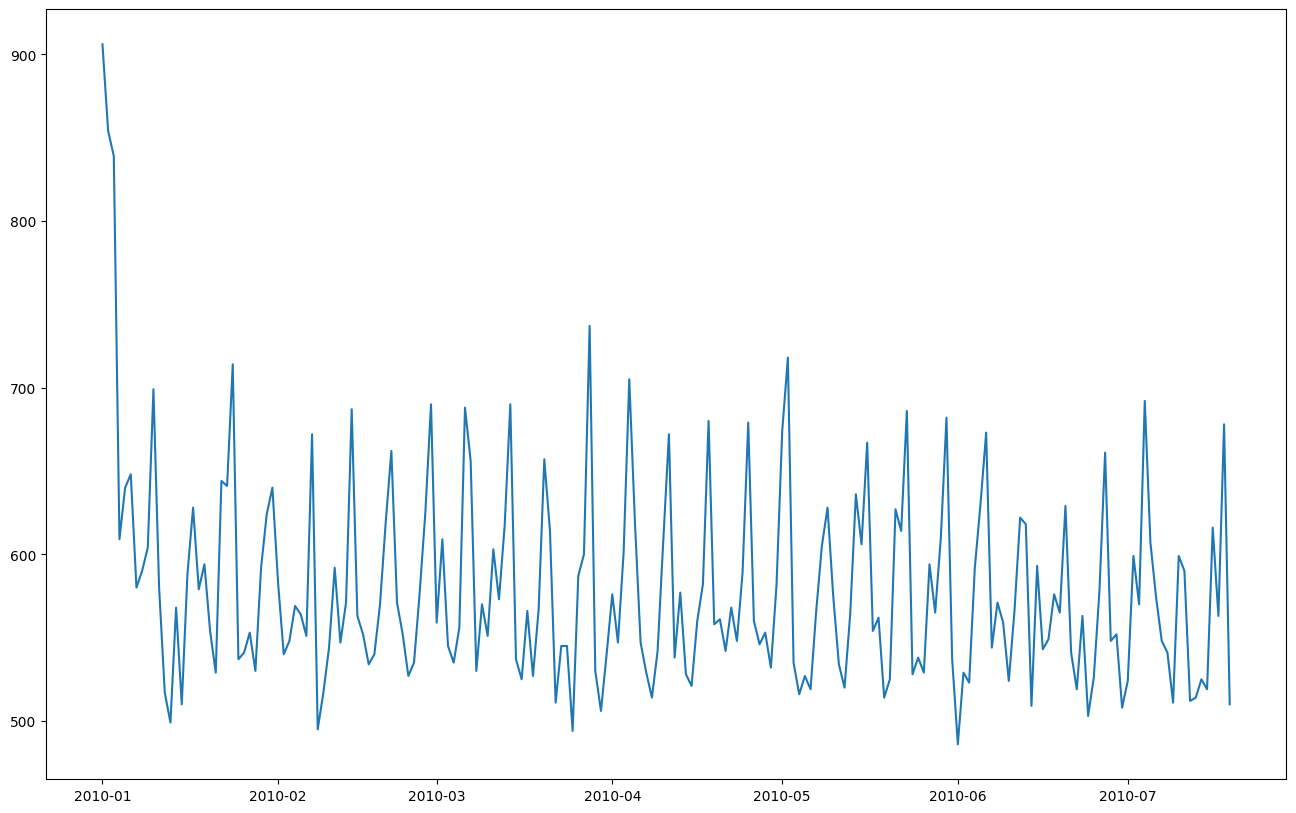

In [341]:
plt.figure(figsize=(16,10))
plt.plot(train[mask]['date'][:200], train[mask]['num_sold'][:200])

In [342]:
from sklearn.model_selection import train_test_split

In [343]:
train.isna().sum() #visualiser si y a pas des liens entre le NA, et qqch

date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

# TREND PREDICTION

In [344]:
len(train.drop_duplicates(subset="date")) #avec mon lag de 400, je perds donc 20% de mon train pour chaque group

2557

In [345]:
def lag_n_ma(df):
    df['lag_30'] = df.groupby(['country', 'store', 'product'])['target'].shift(30)
    df['lag_60'] = df.groupby(['country', 'store', 'product'])['target'].shift(60)
    df['lag_120'] = df.groupby(['country', 'store', 'product'])['target'].shift(120)
    df['lag_180'] = df.groupby(['country', 'store', 'product'])['target'].shift(180)
    df['lag_240'] = df.groupby(['country', 'store', 'product'])['target'].shift(240)
    df['lag_300'] = df.groupby(['country', 'store', 'product'])['target'].shift(300)
    df['lag_400'] = df.groupby(['country', 'store', 'product'])['target'].shift(400)
    
    df['rolling_mean_30'] = df.groupby(['country', 'store', 'product'])['target'].rolling(30).mean().reset_index(level=[0, 1, 2], drop=True)
    df['rolling_mean_60'] = df.groupby(['country', 'store', 'product'])['target'].rolling(60).mean().reset_index(level=[0, 1, 2], drop=True)
    df['rolling_mean_150'] = df.groupby(['country', 'store', 'product'])['target'].rolling(150).mean().reset_index(level=[0, 1, 2], drop=True)
    df['rolling_mean_300'] = df.groupby(['country', 'store', 'product'])['target'].rolling(300).mean().reset_index(level=[0, 1, 2], drop=True)

    return df

In [346]:
train.dtypes

date        datetime64[ns]
country             object
store               object
product             object
num_sold           float64
dtype: object

In [347]:
train["num_sold"].isna().sum()

8871

In [348]:
train.head()

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [349]:
def recursive_preds(model, train, test):

    #preprocess train df
    train['date'] = pd.to_datetime(train['date'])
    train.dropna(axis=0, how='any', subset='num_sold', inplace=True)
    train.rename(columns={'num_sold':'target'}, inplace=True)
    train['target'] = np.log1p(train['target'])
    
    #lags and MA features

    fit_df = train.copy()
    fit_df = lag_n_ma(train)
    
    # time step features
    fit_df['time_step'] = (fit_df['date'] - fit_df['date'].min()).dt.days
    fit_df['time_step_sqrd'] = fit_df['time_step']**2
    fit_df['time_step_cube'] = fit_df['time_step']**3
    fit_df = pd.get_dummies(fit_df, columns=["country", "store", "product"])
    fit_df.dropna(axis=0, how='any', inplace=True)

    X_fit = fit_df.drop(columns=['target', 'date'])
    y_fit = fit_df['target']

    model.fit(X_fit, y_fit)

    #recursive preds :
    test['date'] = pd.to_datetime(test['date'])

    for i in range(len(test)):
        observation = pd.Series(test.iloc[i, :])
        #ma_lags_df = pd.concat(axis=0, [train, observation])
        #return ma_lags_df.tail()

In [350]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

test = recursive_preds(model, train, test)
test

,date,country,store,product,target,lag_30,lag_60,lag_120,lag_180,lag_240,lag_300,lag_400,rolling_mean_30,rolling_mean_60,rolling_mean_150,rolling_mean_300,time_step,time_step_sqrd,time_step_cube,230130
230129,2016-12-31,Singapore,Premium Sticker Mart,Kerneler Dark Mode,7.392032,6.867974,6.923629,6.794587,6.852243,7.226209,7.216709,6.805723,6.986354,6.930171,6.847614,6.959257,2556.0,6533136.0,1.669870e+10,NaN
date,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:00
country,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada
store,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Discount Stickers
product,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holographic Goose


In [16]:
X_train = pd.DataFrame(train.drop(columns=["target", "date"]))
y_train = pd.DataFrame(train.loc[:, "target"])

In [17]:
X_train.columns

Index(['country', 'store', 'product', 'lag_30', 'lag_60', 'lag_120', 'lag_180',
       'lag_240', 'lag_300', 'lag_400', 'rolling_mean_30', 'rolling_mean_60',
       'rolling_mean_150', 'rolling_mean_300', 'time_step', 'time_step_sqrd',
       'time_step_cube'],
      dtype='object')

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

columns_to_scale = [
    'lag_30',
    'lag_60',
    'lag_120',
    'lag_180',
    'lag_240',
    'lag_300',
    'lag_400',
    'rolling_mean_30',
    'rolling_mean_60',
    'rolling_mean_150',
    'rolling_mean_300',
    'time_step',
    'time_step_sqrd',
    'time_step_cube'
]

model = LinearRegression()
std = StandardScaler()
ohe = OneHotEncoder()
tscv = TimeSeriesSplit(n_splits=5)
test = tscv.split(X_train)

In [24]:
test = tscv.split(X_train)

<generator object TimeSeriesSplit.split at 0x000002187F972B60>

In [28]:
def TS_cross_validation(X):
    cv_scores = []
    

,date,country,store,product
id,,,,
230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
230131,2017-01-01,Canada,Discount Stickers,Kaggle
230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
230133,2017-01-01,Canada,Discount Stickers,Kerneler
230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
...,...,...,...,...
328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers


In [ ]:
def predictions(df_train, df_to_predict):
    

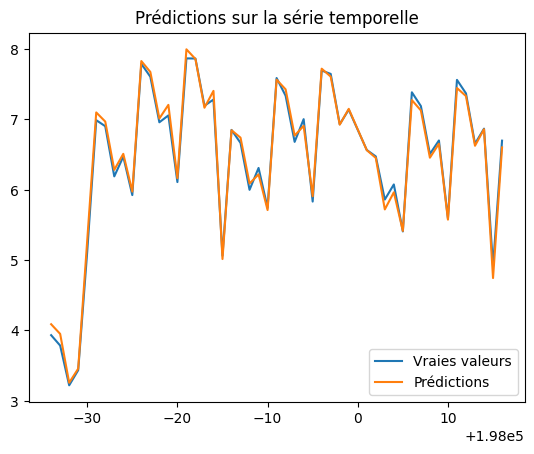

In [96]:
plt.plot(y_testing_fold.index[:50], y_testing_fold[:50], label='Vraies valeurs')
plt.plot(y_testing_fold.index[:50], y_pred[:50], label='Prédictions')
plt.legend()
plt.title('Prédictions sur la série temporelle')
plt.show()


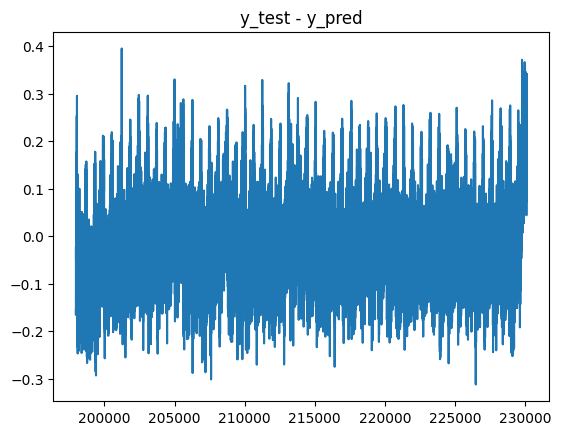

In [101]:
plt.plot(y_testing_fold.index, y_testing_fold - y_pred)
plt.title("y_test - y_pred")
plt.show()

On voit qu'il y a sûrement encore de la seasonality et des cycles

# Submission

In [92]:
test_ = pd.read_csv("test.csv", index_col=0)
test_ = trend_preprocessing(test_, test=True)

In [93]:
test_.tail()

,date,time_step,time_step_sqrd,time_step_cube,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Premium Sticker Mart,store_Stickers for Less,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
id,,,,,,,,,,,,,,,
328675,2019-12-31,1094,1196836,1309338584,0,0,0,0,1,1,0,0,0,0,0
328676,2019-12-31,1094,1196836,1309338584,0,0,0,0,1,1,0,1,0,0,0
328677,2019-12-31,1094,1196836,1309338584,0,0,0,0,1,1,0,0,1,0,0
328678,2019-12-31,1094,1196836,1309338584,0,0,0,0,1,1,0,0,0,1,0
328679,2019-12-31,1094,1196836,1309338584,0,0,0,0,1,1,0,0,0,0,1


In [94]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()